In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import os
from fonctions import *

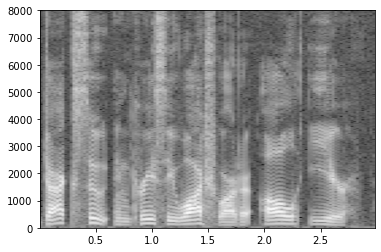

In [3]:

waveform, sample_rate = torchaudio.load("../Data/meme_taille_TEST/sig_1_10.WAV")
spec_br, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = True, mode = 'psd', cmap = 'gray')

In [3]:
######################### MEME TAILLE DE SIGNAUX

"""taille_sig("../Data/speech_TEST/TIMIT_TEST/DR1")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR2")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR3")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR4")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR5")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR6")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR7")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR8")"""

'RSB = input(\'entrer le RSB voulu\')\nbruit, sample_rate_bruit = torchaudio.load("../Data/babble.wav")\nbruit_rs = torchaudio.transforms.Resample(sample_rate_bruit, 16000)(bruit)\nfor subdir, dirs, files in os.walk("../Data/meme_taille_TEST"):\n    for file in files:\n        if (\'.WAV\' in file):\n            subpath = os.path.join(subdir, file)\n            save_bruit(subpath, bruit, bruit_rs, RSB)'

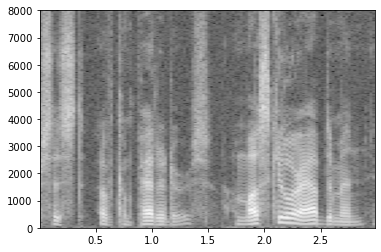

In [134]:
####################### SIGNAUX NON BRUITÉS

for subdir, dirs, files in os.walk("../Data/meme_taille_TEST"):
    for file in files:
            subpath = os.path.join(subdir, file)
            waveform, sample_rate = torchaudio.load(subpath)
            spec, f, t, im = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = True, mode = 'psd', cmap = 'gray')
            
            #on ajoute le spectro au dossier
             
            path_list = subpath.split("/")
            br_name = 'nb_' + path_list[3][:-3] + 'bin'

            np.savetxt('../Data/sig/non_bruité/' + br_name, spec) 
            """m = np.loadtxt("Image.bin")
            plt.axis('off')
            plt.savefig('../Data/sig/non_bruité/' + br_name,bbox_inches='tight')
            plt.clf()
            plt.cla()"""
            
######################## BRUITAGE DES SIGNAUX

"""RSB = input('entrer le RSB voulu')
bruit, sample_rate_bruit = torchaudio.load("../Data/babble.wav")
bruit_rs = torchaudio.transforms.Resample(sample_rate_bruit, 16000)(bruit)
for subdir, dirs, files in os.walk("../Data/meme_taille_TEST"):
    for file in files:
        if ('.WAV' in file):
            subpath = os.path.join(subdir, file)
            save_bruit(subpath, bruit, bruit_rs, RSB)"""
   

In [4]:
############################### MISE EN PLACE DU CNN
import torch
from torch.autograd import Variable
from torch.optim import Adam, SGD

import torch.nn as nn
import torch.optim as optim

batch_size = 5
epochs = 20
learning_rate = 1e-3

In [26]:
############################## CRÉATION DU DATASET

import torch
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torchaudio
import numpy as np
import matplotlib.image as mpimg
from torch import tensor
import os
from torchvision.transforms import ToTensor
from PIL import Image 

def my_loader(filename):
    return np.loadtxt(filename, dtype=np.double)
    

data = torchvision.datasets.DatasetFolder('../Data/sig', transform = ToTensor(), loader = my_loader, extensions = '.bin')
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [21]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=1
        )
        self.encoder_hidden_layer2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=1
        )
        self.poolp = nn.MaxPool2d(
            kernel_size=2, padding=(1,1)
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.decoder_hidden_layer = nn.ConvTranspose2d(
            in_channels=20, out_channels=10, kernel_size=2, stride=2
        )
        self.decoder_output_layer = nn.ConvTranspose2d(
            in_channels=10, out_channels=1, kernel_size=2, stride=2
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer1(features)
        activation = torch.relu(activation)
        print("couche conv 1", activation.size())
        code = self.pool(activation)
        code = torch.sigmoid(code)
        print("couche maxpool 1", code.size())
        activation = self.encoder_hidden_layer2(code)
        activation = torch.relu(activation)
        print("couche conv 2", activation.size())
        code = self.poolp(activation)
        code = torch.sigmoid(code)
        print("couche maxpool 2", code.size())
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        print("couche decode 1", activation.size())
        reconstructed = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(reconstructed)
        print("couche decode 2", reconstructed.size())
        return reconstructed

In [22]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [23]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in test_loader:
        
        batch_features = batch_features.to(device)
        print(batch_features.type())
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(torch.tensor(batch_features))
        print(outputs.size())
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(test_loader)
    
    # save the weigth
    torch.save(model.state_dict(), "model"+str(epoch))
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

NameError: name 'double' is not defined